# run_car

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
dyn_plot = True
class DynamicUpdate():
    def on_launch(self):
        #Set up plot
        self.figure, self.ax = plt.subplots()
        self.lines, = self.ax.plot([],[])
        #Autoscale on unknown axis and known lims on the other
        self.ax.set_autoscaley_on(True)
        self.ax.set_autoscalex_on(True)
        #Other stuff
        self.ax.grid()

    def on_running(self, xdata, ydata):
        #Update data (with the new _and_ the old points)
        self.lines.set_xdata(xdata)
        self.lines.set_ydata(ydata)
        #Need both of these in order to rescale
        self.ax.relim()
        self.ax.autoscale_view()
        #We need to draw *and* flush
        self.figure.canvas.draw()
        self.figure.canvas.flush_events()

In [ ]:
import datetime
import numpy as np
import random

In [ ]:
from cars.world import SimpleCarWorld
from cars.agent import SimpleCarAgent
from cars.physics import SimplePhysics
from cars.track import generate_map

In [ ]:
from tqdm import tqdm_notebook

In [ ]:
from functools import reduce

In [ ]:
import pandas as pd

In [ ]:
def create_map(seed, agent):
    np.random.seed(seed)
    random.seed(seed)
    m = generate_map(8, 5, 3, 3)
    w = SimpleCarWorld([agent], m, SimplePhysics, None, timedelta=0.2)
    return w

In [ ]:
import seaborn as sns

# Параметры

In [ ]:
map_seeds = [3, 13, 23]

In [ ]:
# За сколько шагов модель начинает учитывать вознаграждение
map_seed = map_seeds[0]

# Нарабатываем данные, учимся и оцениваемся

In [ ]:
log_list = []

In [ ]:
def norm_y(y):
    return y / 15.0

In [ ]:
def mine_data(agent, action_trainer_params,
              clear_history, map_seed, steps,
              epochs, mini_batch_size, eta, reward_shift, alpha):
    agent.action_trainer.set_params(**action_trainer_params)
    if clear_history:
        agent.clear_history()
    
    # сбрасываем статистику
    agent.action_trainer.reset_steps()
    
    #mine data
    w = create_map(seed=map_seed, agent=agent)
    w.run(steps=tqdm_notebook(range(steps), desc="train", leave=False), visual=False, save=False)

    steps_str = "total: {:d}, bad: {:.4f}, good: {:.4f}, diff: {:.4f}, other: {:.4f}".format(
        agent.action_trainer.steps[0],
        agent.action_trainer.steps[1] / agent.action_trainer.steps[0],
        agent.action_trainer.steps[2] / agent.action_trainer.steps[0],
        agent.action_trainer.steps[3] / agent.action_trainer.steps[0],
        1 - sum(agent.action_trainer.steps[1:]) / agent.action_trainer.steps[0])
    
    # prepare train data
    X_train = np.concatenate([agent.sensor_data_history, agent.chosen_actions_history], axis=1)
    y_train = np.array(agent.reward_history)
    # сглаживаем пики, чтобы сеть небольшая сеть могла дать адекватное предсказание
    mean_train_revard = y_train.mean()
    y_train = norm_y(y_train)
    
    y_train = np.pad(y_train, (0, reward_shift + 1), mode="constant")
    y_train = reduce(lambda a, b: a + b, [y_train[i:(i - reward_shift - 1)] * (alpha ** (i - 1))
                                          for i in range(1, reward_shift+1)])

    #train NN
    train_data = [(x[:, np.newaxis], y) for x, y in zip(X_train, y_train)]
    train_rmse_before = agent.neural_net.evaluate(X_train.T, y_train)
    next(agent.neural_net.SGD(training_data=train_data,
                         epochs=epochs,
                         mini_batch_size=mini_batch_size,
                         eta=eta))
    train_rmse_after = agent.neural_net.evaluate(X_train.T, y_train)

    # evaluate
    w = create_map(seed=map_seed, agent=agent)
    mean_test_reward = w.evaluate_agent(agent, steps=tqdm_notebook(range(800), desc="test", leave=False), visual=False)
    log_message = f"""map_seed = {map_seed}
train_rmse_before = {train_rmse_before:.9f}, train_rmse_after = {train_rmse_after:.9f}, 
mean_train_revard = {mean_train_revard:.3f}, mean_test_reward  = {mean_test_reward:.3f},
steps = {steps_str}"""

    log_list.append(log_message)
    if not dyn_plot:
        chart_count = agent.neural_net.num_layers
        plt.figure(figsize=(5 * chart_count, 2))
        for l in range(chart_count - 1):
            plt.subplot(1, chart_count, l+1)
            ax = sns.heatmap(agent.neural_net.weights[l])

        plt.subplot(1, chart_count, chart_count)    
        plt.text(0.05, 0.95, log_message, size=12, ha='left', va='top', family='monospace')

        plt.show()
    else:
        print(log_message)

In [ ]:
kvparams = {
    "clear_history": False,
    "map_seed": map_seed,
    "epochs": 100,
    "mini_batch_size": 50,
    "eta": 0.5,
    "reward_shift": 6,
    "alpha": 0.8
}

act_trainer = {
    "low": 0.0,
    "high": 0.0,
    "random_default": 0.8,
    "random_bad": 0.8,
    "random_good": 0.8,
    "random_diff": 0.8,
    "bad_choice_p": 0.01
}

random.seed(42)
np.random.seed(42)
agent1 = SimpleCarAgent(name="Ivan", history_data=10000)

In [ ]:
print("\n\n".join(log_list) + "\n----\n")
for _ in tqdm_notebook(range(1), desc="main"):
    mine_data(agent1, act_trainer, steps=4000, **kvparams)

In [35]:
y_train_setting = norm_y(np.array(agent1.reward_history))

mn = y_train_setting.min()
mx = y_train_setting.max()
act_trainer["low"] = -0.6
act_trainer["high"] = -0.1

act_trainer["random_default"] = 0.50
act_trainer["random_bad"] = 0.80
act_trainer["random_good"] = 0.05
act_trainer["random_diff"] = 0.05

act_trainer["bad_choice_p"] = 0.01

In [37]:
print("\n\n".join(log_list) + "\n----\n")

for _ in tqdm_notebook(range(5), desc="main"):
    mine_data(agent1, act_trainer, steps=4000, **kvparams)
    print("")

map_seed = 3
train_rmse_before = 1.345058499, train_rmse_after = 0.166510999, 
mean_train_revard = -0.476, mean_test_reward  = -0.374,
steps = total: 4000, bad: 0.0132, good: 0.9653, diff: 0.0295, other: -0.0080

map_seed = 3
train_rmse_before = 0.227665653, train_rmse_after = 0.199094318, 
mean_train_revard = -0.463, mean_test_reward  = -0.659,
steps = total: 4000, bad: 0.0000, good: 0.9197, diff: 0.0000, other: 0.0803

map_seed = 3
train_rmse_before = 0.223832554, train_rmse_after = 0.199469730, 
mean_train_revard = -0.552, mean_test_reward  = -0.530,
steps = total: 4000, bad: 0.0278, good: 0.8648, diff: 0.0000, other: 0.1075

map_seed = 3
train_rmse_before = 0.213113293, train_rmse_after = 0.194649719, 
mean_train_revard = -0.589, mean_test_reward  = -0.433,
steps = total: 4000, bad: 0.0105, good: 0.9287, diff: 0.0000, other: 0.0607

map_seed = 3
train_rmse_before = 0.263030996, train_rmse_after = 0.185160274, 
mean_train_revard = -0.581, mean_test_reward  = -0.812,
steps = total: 4

# Смотрим вживую

In [22]:
def visualize(agent, map_seed):
    agent.evaluate_mode=True
    print("visualize on map = {}".format(map_seed))
    agent.clear_history()
    w = create_map(seed=map_seed, agent=agent)
    w.run(steps=None, visual=True, save=False)

In [38]:
visualize(agent1, map_seed)

visualize on map = 3


# Отладка

In [ ]:
raise Exception("Здесь отладка")

In [24]:
agent_dbg = agent1

In [57]:
agent_dbg.clear_history()
#mine data
w = create_map(seed=map_seed, agent=agent_dbg)
w.run(steps=tqdm_notebook(range(10000), desc="train", leave=False), visual=False, save=False)

In [58]:
# prepare train data
X_train = np.concatenate([agent_dbg.sensor_data_history, agent_dbg.chosen_actions_history], axis=1)
y_train = np.array(agent_dbg.reward_history)
mean_train_revard = y_train.mean()
y_train = norm_y(y_train)
y_clean = y_train.copy()

mean_train_revard

-3.0936396413332665

In [59]:
reward_shift = 6
alpha = 0.8

In [60]:
y_train = np.pad(y_train, (0, 2 * reward_shift), mode="constant")
y_train = reduce(lambda a, b: a + b, [y_train[i:(-2 * reward_shift + i)] * (alpha ** (i - 1))
                                      for i in range(1, reward_shift+1)])

In [61]:
y_predict = agent_dbg.neural_net.feedforward(X_train.T)

In [62]:
pd_visual = pd.DataFrame(X_train,
                         columns=["velocity", "angle"] +
                         ["lid{}".format(i) for i in range(agent_dbg.rays)] +
                         ["steering", "acceleration"])
pd_visual["y_clean"] = y_clean
pd_visual["y_train"] = y_train
pd_visual["y_predict"] = y_predict.flatten()

In [44]:
(pd_visual.y_clean[200:] < 0).argmax()

221

In [45]:
pd_visual.loc[215:235]

,velocity,angle,lid0,lid1,lid2,lid3,lid4,steering,acceleration,y_clean,y_train,y_predict
215,0.819387,0.838510,5.283656,2.005527,1.353478,0.814809,1.154740,-1.0,0.75,0.000000,-0.330739,-0.024516
216,0.846171,0.916519,2.511149,2.026470,1.658331,0.773863,0.816689,1.0,0.75,0.000000,-0.413424,-0.061725
217,0.846387,0.909602,8.666171,1.821427,1.484904,0.694621,0.733941,1.0,0.75,0.000000,-0.516780,-0.010559
218,0.872565,0.814704,3.888362,1.466825,0.937750,0.562694,0.691128,1.0,0.75,0.000000,-0.645975,-0.248254
219,0.897787,0.696451,2.373320,1.219244,0.595642,0.429305,0.619068,1.0,0.75,0.000000,-0.807469,-0.566983
220,0.922334,0.560926,1.639777,1.040797,0.339073,0.284435,0.494367,1.0,0.75,0.000000,-1.009336,-0.844077
221,0.946253,0.414480,1.219832,0.328732,0.122866,0.118089,0.260626,1.0,0.75,-1.009336,0.000000,-0.039911
222,0.473126,-0.414480,0.260626,3.978079,2.931655,11.125310,1.219832,-1.0,0.75,0.000000,0.000000,0.041188
223,0.485019,-0.490049,0.388278,4.170754,2.836541,12.696434,1.417001,-1.0,0.75,0.000000,0.000000,0.041244
224,0.529312,-0.732577,0.356343,5.496023,2.907299,2.727424,2.406153,1.0,0.75,0.000000,0.000000,0.048417


In [46]:
from cars.utils import Action

In [47]:
sensor_info = pd_visual.loc[219].values[:7]
rewards_to_controls_map = []
# дискретизируем множество значений, так как все возможные мы точно предсказать не сможем
for steering in np.linspace(-1, 1, 3):  # выбирать можно и другую частоту дискретизации, но
    for acceleration in np.linspace(-0.75, 0.75, 3):  # в наших тестах будет именно такая
        action = Action(steering, acceleration)
        agent_vector_representation = np.append(sensor_info, action)
        agent_vector_representation = agent_vector_representation.flatten()[:, np.newaxis]
        predicted_reward = float(agent_dbg.neural_net.feedforward(agent_vector_representation))
        rewards_to_controls_map.append((predicted_reward, action))

rewards_to_controls_map

[(-0.2225219688657079, Action(steering=-1.0, acceleration=-0.75)),
 (-0.29714941489615987, Action(steering=-1.0, acceleration=0.0)),
 (-0.3997094864516721, Action(steering=-1.0, acceleration=0.75)),
 (-0.1985839663423207, Action(steering=0.0, acceleration=-0.75)),
 (-0.28193323672025167, Action(steering=0.0, acceleration=0.0)),
 (-0.42582900565653586, Action(steering=0.0, acceleration=0.75)),
 (-0.19612387452231497, Action(steering=1.0, acceleration=-0.75)),
 (-0.3314555004694726, Action(steering=1.0, acceleration=0.0)),
 (-0.566982500438977, Action(steering=1.0, acceleration=0.75))]

In [48]:
sorted(rewards_to_controls_map, key=lambda x: x[0])[-1]

(-0.19612387452231497, Action(steering=1.0, acceleration=-0.75))

In [49]:
sensor_info = pd_visual.loc[223].values[:7]
rewards_to_controls_map = []
# дискретизируем множество значений, так как все возможные мы точно предсказать не сможем
for steering in np.linspace(-1, 1, 3):  # выбирать можно и другую частоту дискретизации, но
    for acceleration in np.linspace(-0.75, 0.75, 3):  # в наших тестах будет именно такая
        action = Action(steering, acceleration)
        agent_vector_representation = np.append(sensor_info, action)
        agent_vector_representation = agent_vector_representation.flatten()[:, np.newaxis]
        predicted_reward = float(agent_dbg.neural_net.feedforward(agent_vector_representation))
        rewards_to_controls_map.append((predicted_reward, action))

rewards_to_controls_map

[(0.0399886103913048, Action(steering=-1.0, acceleration=-0.75)),
 (0.04063530865064863, Action(steering=-1.0, acceleration=0.0)),
 (0.04124446534667758, Action(steering=-1.0, acceleration=0.75)),
 (0.03996316367889352, Action(steering=0.0, acceleration=-0.75)),
 (0.040611711030015596, Action(steering=0.0, acceleration=0.0)),
 (0.041222754166873654, Action(steering=0.0, acceleration=0.75)),
 (0.03993753525781213, Action(steering=1.0, acceleration=-0.75)),
 (0.04058789479289787, Action(steering=1.0, acceleration=0.0)),
 (0.04120077385218457, Action(steering=1.0, acceleration=0.75))]

In [50]:
sorted(rewards_to_controls_map, key=lambda x: x[0])[-1]

(0.04124446534667758, Action(steering=-1.0, acceleration=0.75))

In [63]:
plt.ion()

<IPython.core.display.Javascript object>


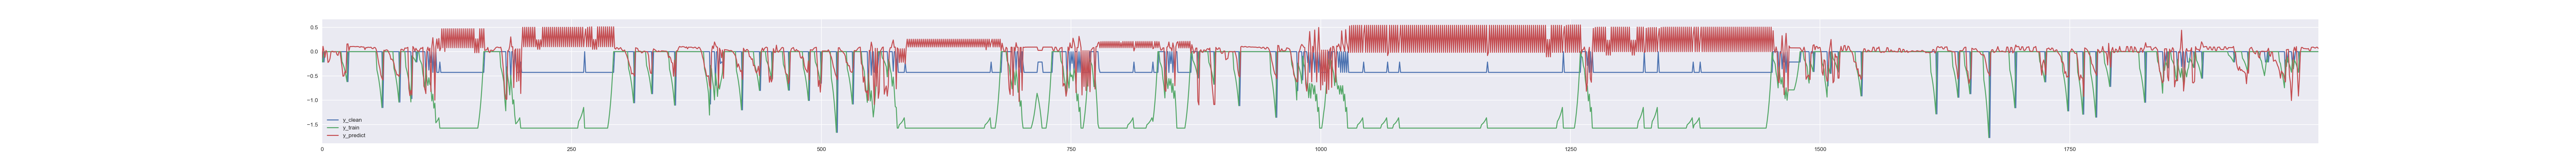

In [64]:
pd_visual[:2000].plot(y=["y_clean", "y_train", "y_predict"], figsize=(64, 4))

In [65]:
rmse_before = ((pd_visual.y_train - pd_visual.y_predict)**2).mean() ** 0.5
rmse_before

1.1072264202549833

In [66]:
train_data = [(x[:, np.newaxis], y) for x, y in zip(X_train, y_train)]

In [67]:
from learning_algorithms.network import Network
agent_dbg.neural_net = Network([9, 12, 1], output_function=lambda x: x, output_derivative=lambda x: 1)

In [68]:
epoch_num = 1
dyp_x = []
dyp_y = []

<IPython.core.display.Javascript object>


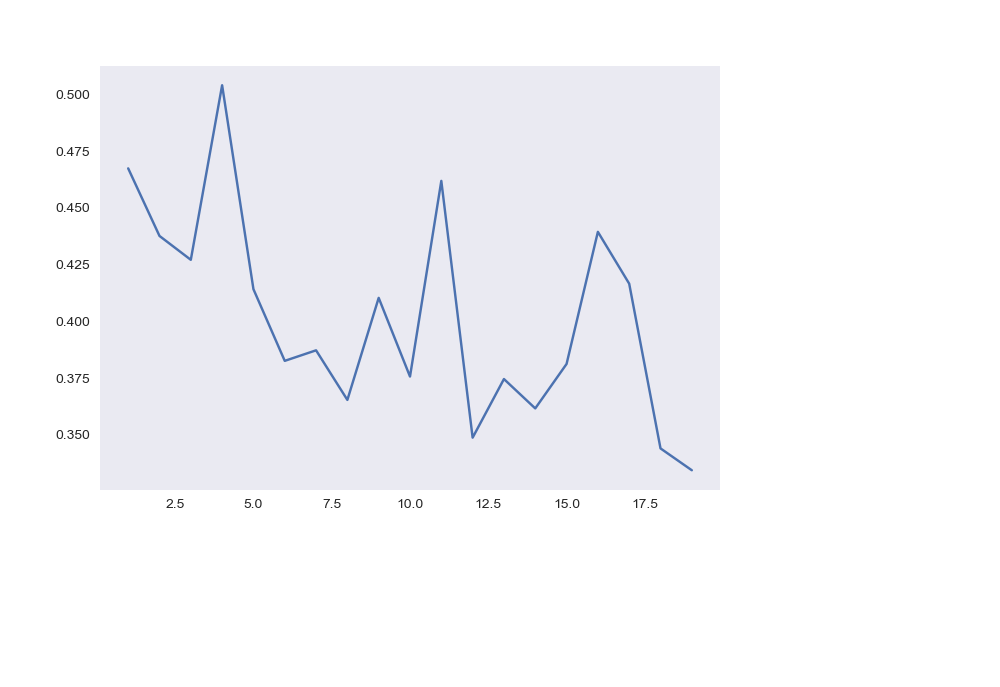

In [ ]:
plt.ion()
dyp = DynamicUpdate()
dyp.on_launch()

try:
    for res in agent_dbg.neural_net.SGD(
            training_data=train_data,
            epochs=100,
            mini_batch_size=50,
            eta=0.5,
            test_data=(X_train.T, y_train)):
        dyp_x.append(epoch_num)
        epoch_num += 1
        dyp_y.append(res)
        if epoch_num % 10 == 0:
            dyp.on_running(dyp_x, dyp_y)
except KeyboardInterrupt:
    print("min rmse: {}".format(min(dyp_y)))

In [ ]:

              epochs, mini_batch_size, eta, reward_shift, alpha):

    




    # evaluate
    w = create_map(seed=map_seed, agent=agent)
    mean_test_reward = w.evaluate_agent(agent, steps=tqdm_notebook(range(800), desc="test", leave=False), visual=False)
    log_message = f"""map_seed = {map_seed}
agent_random_action = {agent_random_action:.2f}
train_rmse = {train_rmse:.9f}
mean_train_revard = {mean_train_revard:.3f}
mean_test_reward  = {mean_test_reward:.3f}"""

    chart_count = agent.neural_net.num_layers
    plt.figure(figsize=(5 * chart_count, 2))
    for l in range(chart_count - 1):
        plt.subplot(1, chart_count, l+1)
        ax = sns.heatmap(agent.neural_net.weights[l])
        
    plt.subplot(1, chart_count, chart_count)    
    plt.text(0.05, 0.95, log_message, size=12, ha='left', va='top', family='monospace')
    
    plt.show()